# **Milestone 2**

Nama    : Ardianto

Batch   : RMT204

---

AutoMobile Inc. adalah perusahan baru yang bergerk dalam bidang jual beli mobil bekas. Perusahaan tersebut menyediakan platform online dimana user bisa memasang iklan untuk menjual mobil, atau dimana user bisa membeli mobil bekas. Namun, terdapat masalah dimana user kadang memberikan harga yang tidak masuk akal. Misalnya, user memasang harga yang terlalu murah atau terlalu mahal. Untuk itu, perlu dibuat sebuah sistem dimana user bisa diberikan rekomendasi harga yang cocok sesuai dengan tipe atau model mobil yang ingin dijual atau dibeli. Sistem tersebut bisa membantu user dalam menentukan harga jual, dan juga membantu pembeli apakah harga yang dipasang rasional atau tidak. Sistem tersebut bisa dibuat menggunakan model Mechine Learning Regression.

`Model mechine learning` yang digunakan: KNN, SVM, DecisionTree, dan Randomforest <br>
`Dataset` : Used Car Dataset <br>
`Source` : https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes?select=vw.csv <br>
`Chosen Manufacturer`: Audi, Toyota, Hyundai, dan BMW 

### **A. Library Import**

In [1]:
# general and visualization libraries
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

# model regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor


# Splitting
from sklearn.model_selection import train_test_split

# untuk handling outliers
from feature_engine.outliers import Winsorizer

# model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#cross val
from sklearn.model_selection import cross_val_score,GridSearchCV, RandomizedSearchCV

# Anova test
from scipy.stats import f_oneway

# scaling and encoding
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder

# Model Saving
import joblib as joblib

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


### **B. Data Loading**

##### Individual dataset

In [2]:
audi = pd.read_csv('dataset/audi.csv')
audi['company']='Audi' #masukan kolom baru brand

bmw = pd.read_csv('dataset/bmw.csv')
bmw['company']='BMW' #masukan kolom baru brand

toyota = pd.read_csv('dataset/toyota.csv')
toyota['company']='Toyota' #masukan kolom baru brand

hyundai = pd.read_csv('dataset/hyundai.csv')
hyundai['company']='Hyundai' #masukan kolom baru brand

##### Combined Dataset

In [3]:
dataset = pd.concat([audi, bmw, toyota,hyundai], axis=0) # gabung berdasarkan axis=0
dataset.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,company
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4,Audi
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0,Audi
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4,Audi
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0,Audi
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0,Audi


##### Column Descriptions
``` sql
    `model` = Tipe atau model mobil (categorical - nominal)
    `year` = Tahun pembuatan mobil (categorical - ordinal)
    `price` = Harga (dalam Pound Sterling - numerical) 
    `transmission` = Tipe transmisi mobil (categorical - nominal)
    `mileage` = Jumlah jarak tempuh dalam miles (numerical)
    `fuelType` = Jenis bahan bakar (cateogrical - nominal)
    `tax` = Jumlah pajak dalam Pound Sterling
    `mpg`= Miles per Gallon (1 gallon = 3.78541 liter - numerical) 
    `engineSize` = Ukuran mesin (Numerical)
    `company` = Brand atau nama perusahaan pembuat mobil (categorical - nominal)
```

##### Dataset `info()`

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33047 entries, 0 to 4859
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         33047 non-null  object 
 1   year          33047 non-null  int64  
 2   price         33047 non-null  int64  
 3   transmission  33047 non-null  object 
 4   mileage       33047 non-null  int64  
 5   fuelType      33047 non-null  object 
 6   tax           33047 non-null  int64  
 7   mpg           33047 non-null  float64
 8   engineSize    33047 non-null  float64
 9   company       33047 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 2.8+ MB


Dari hasli info per kolom pada data, tidak terdapat kolom dengan missing value, hal ini tentu memudahkan analisa.

##### Removing White Space From Model Column

In [5]:
dataset['model'] = dataset['model'].str.strip() # mengahapus spasi di awal dan di akhir string

##### Dataset Size

In [6]:
row, column = dataset.shape

print(f"Terdapat {row} baris dan {column} kolom pada data")

Terdapat 33047 baris dan 10 kolom pada data


##### Duplicate Checking

In [7]:
dataset.duplicated().sum()

345

In [8]:
dataset.drop_duplicates(inplace=True) # menghapus duplikat data
dataset.duplicated().sum()

0

Terdapat data duplikat sebanyak 758, data duplikat dihapus sebab data duplikat tidak dibutuhkan. 

Data Describe -  Summary Stats

In [9]:
dataset.describe() # describe summary stats

,year,price,mileage,tax,mpg,engineSize
count,32702.000000,32702.000000,32702.000000,32702.000000,32702.000000,32702.000000
mean,2017.008562,19208.265458,24297.554156,120.650878,55.624170,1.846884
std,2.207360,11137.812870,22497.565178,67.130348,21.721951,0.605399
min,1996.000000,850.000000,1.000000,0.000000,1.100000,0.000000
25%,2016.000000,11490.000000,6724.250000,125.000000,45.600000,1.500000
50%,2017.000000,16950.000000,18600.500000,145.000000,54.300000,2.000000
75%,2019.000000,23991.000000,34749.500000,145.000000,62.800000,2.000000
max,2020.000000,145000.000000,323000.000000,580.000000,470.800000,6.600000


Terdapat anomaly pada tahun, nilai max pada tahun 2060. Dengan asumsi kesalahan pengetikan, seharusnya value tersebut 2006. Data tersebut akan dikoreksi.

In [10]:
dataset.loc[dataset['year']==2060,'year']=2006 # mengganti value 2060 ke 2006
dataset.describe()

,year,price,mileage,tax,mpg,engineSize
count,32702.000000,32702.000000,32702.000000,32702.000000,32702.000000,32702.000000
mean,2017.008562,19208.265458,24297.554156,120.650878,55.624170,1.846884
std,2.207360,11137.812870,22497.565178,67.130348,21.721951,0.605399
min,1996.000000,850.000000,1.000000,0.000000,1.100000,0.000000
25%,2016.000000,11490.000000,6724.250000,125.000000,45.600000,1.500000
50%,2017.000000,16950.000000,18600.500000,145.000000,54.300000,2.000000
75%,2019.000000,23991.000000,34749.500000,145.000000,62.800000,2.000000
max,2020.000000,145000.000000,323000.000000,580.000000,470.800000,6.600000


Value berhasil diperbaiki.

### **C. EDA**

Pada bagian ini dilakukan eksplorasi untuk memahami data lebih dalam termasuk dengan mencari tahu distribusi data, korelasi atau hubungan antar kolom dan eksplorasi berdasarkan business domain.

##### 1. Distribusi Data

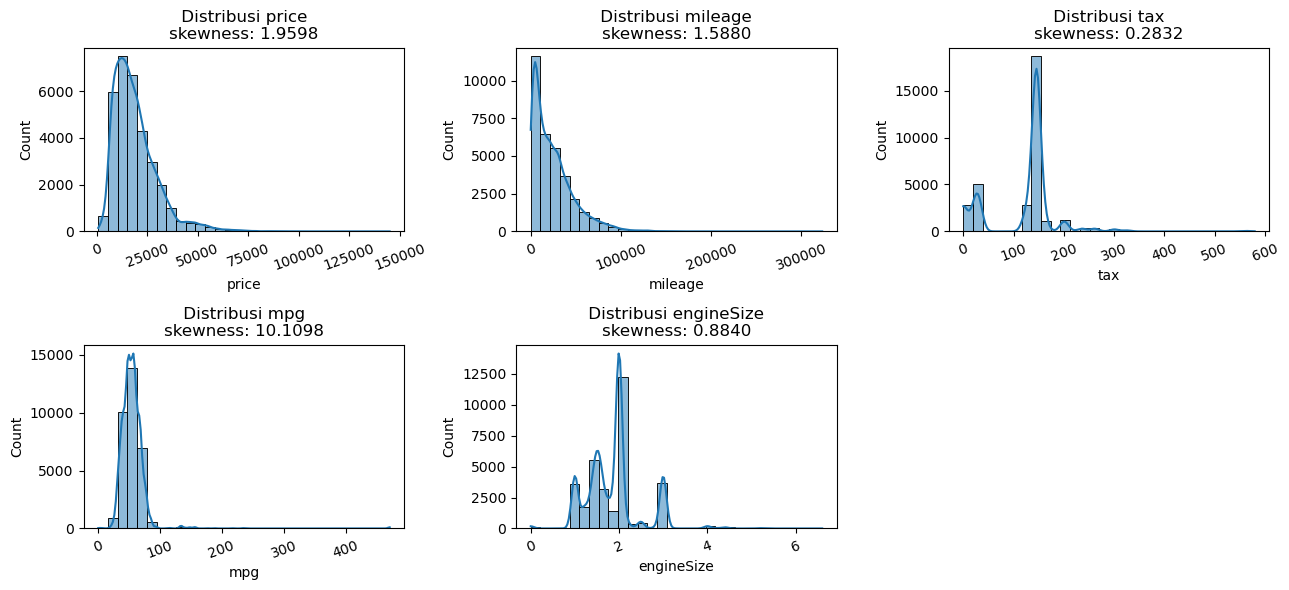

In [11]:
# list nama kolom
cols = dataset[['price', 'mileage', 'tax', 'mpg', 'engineSize']]
# figur size
plt.figure(figsize=(13,6))

# iterasi untuk membuat chart
for i, col in enumerate(cols):
    plt.subplot(2,3, i+1) # subplot
    sns.histplot(dataset[col], kde=True, bins=30) #histogram plot
    plt.title(f' Distribusi {col} \nskewness: {dataset[col].skew():.4f}') # judul plot beserta skewness
    plt.xticks(rotation=20)
plt.tight_layout()

Terlihat hanya kolom tax yang memiliki skewness mendekati normal semetara kolom lain memiliki skewness yang tinggi.

##### 2. Korelasi antar fitur numerik

Disini akan ditampilkan heatmap berdasarkan spearman correlation karena kolom tidak memiliki distribusi normal

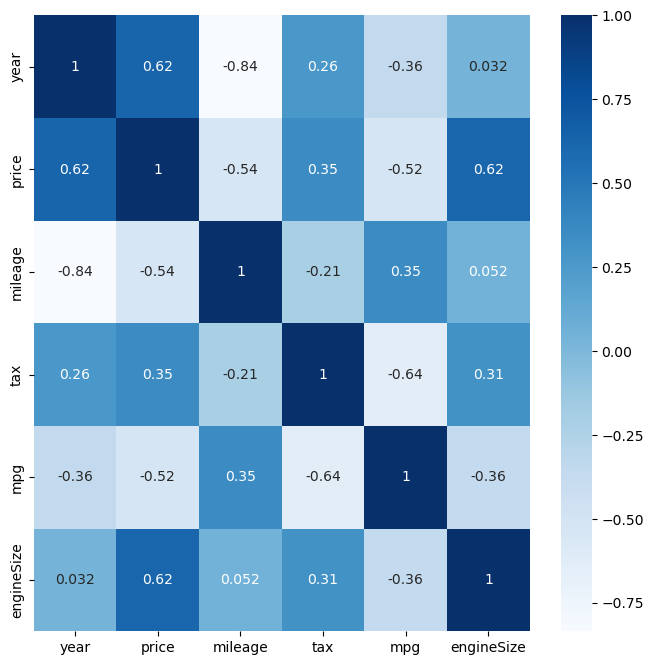

In [12]:
numeric=dataset.select_dtypes(np.number) # select number data
plt.figure(figsize=(8,8)) # figure
sns.heatmap(numeric.corr("spearman"), annot=True, cmap='Blues') #heatmap dengan spearman
plt.show()

- Nilai korelasi terkuat terhadap price ada pada variable year dan engine Size.
- Sedangkan variable yang paling lemah ada pada kolom Tax

##### 3. Linearitas antara price dengan variable lain 

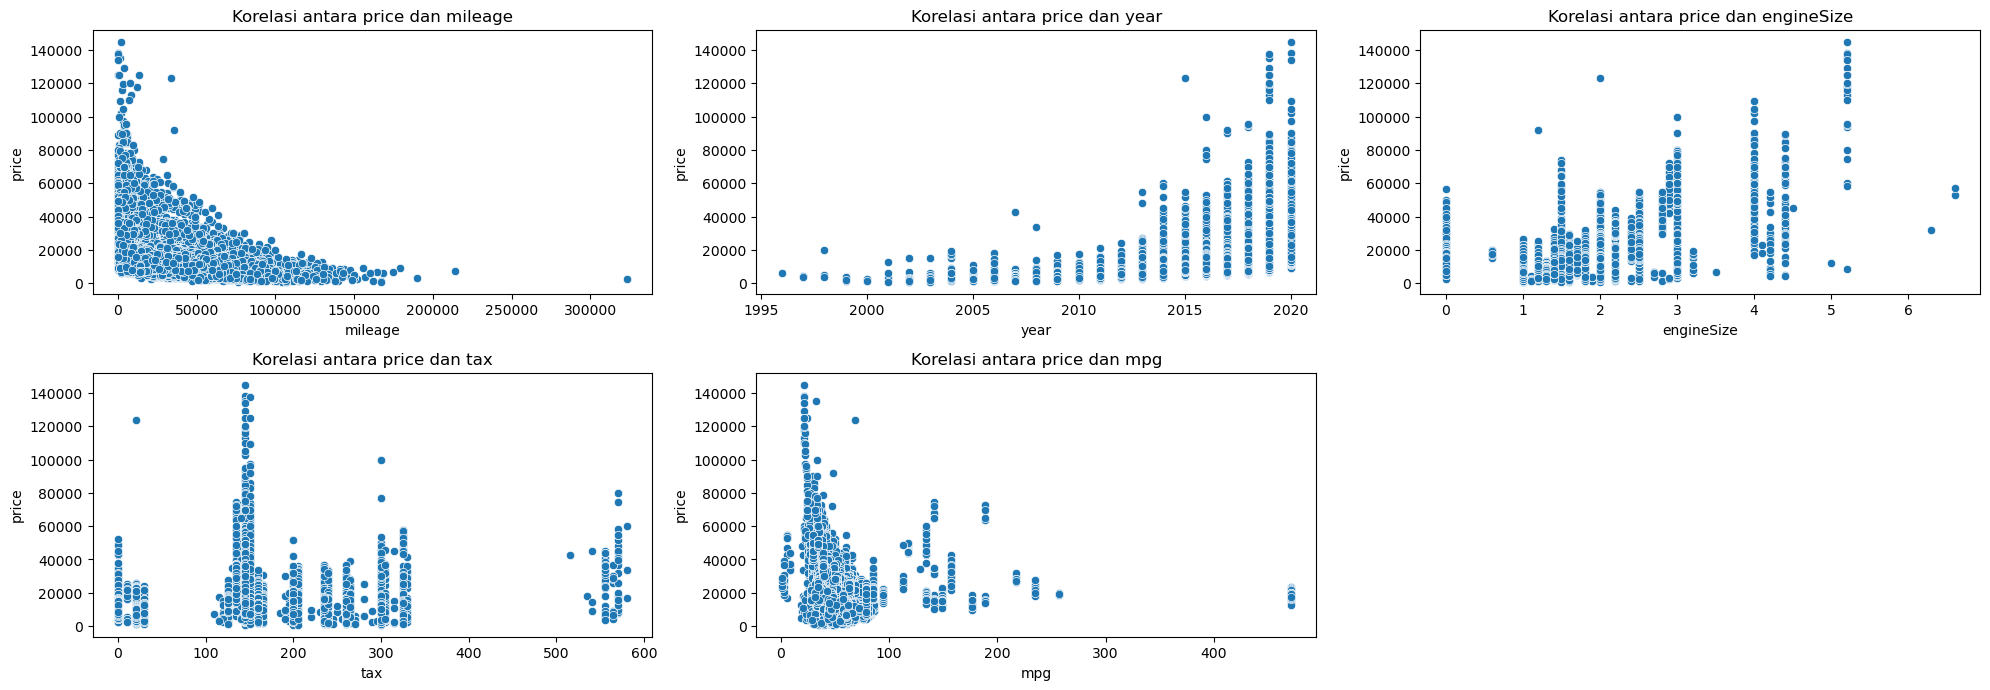

In [13]:
pair = ['mileage', 'year','engineSize', 'tax', 'mpg'] # list kolom supaya price tidak masuk ke x
plt.figure(figsize=(20,10)) # figure
for i, col in enumerate(pair):
    plt.subplot(3,3,i+1) # subplot
    sns.scatterplot(dataset, y='price', x=col) # scatter
    plt.title(f'Korelasi antara price dan {col}') # title
plt.tight_layout()

Dari chart di atas dapat dikatakan:
- Semakin tinggi jarak tempuh (mileage) sebuah mobil, maka semakin murah harganya. Mobil dengan jarak tempuh yang sedikit, cenderung memiliki harga yang tinggi.
- Semakin muda usia mobil, harga nya pun semakin mahal. 
- Untuk engineSize, tidak terlalu terlihat pola pada scatter. Namun, kita bisa sedikitnya melihat bahwa ada kecenderungan ketika engineSize semakin besar, maka harga cenderung lebih mahal.
- Sedangkan untuk pajak, tidak terlihat pola yang jelas. 
- Hubungan antara price dan mpg menunjukan bahwa semakin efisien konsumsi bahan bakar mobil, maka harga cenderung bisa lebih mahal.

##### 4. Perkembangan Harga Per Tahun

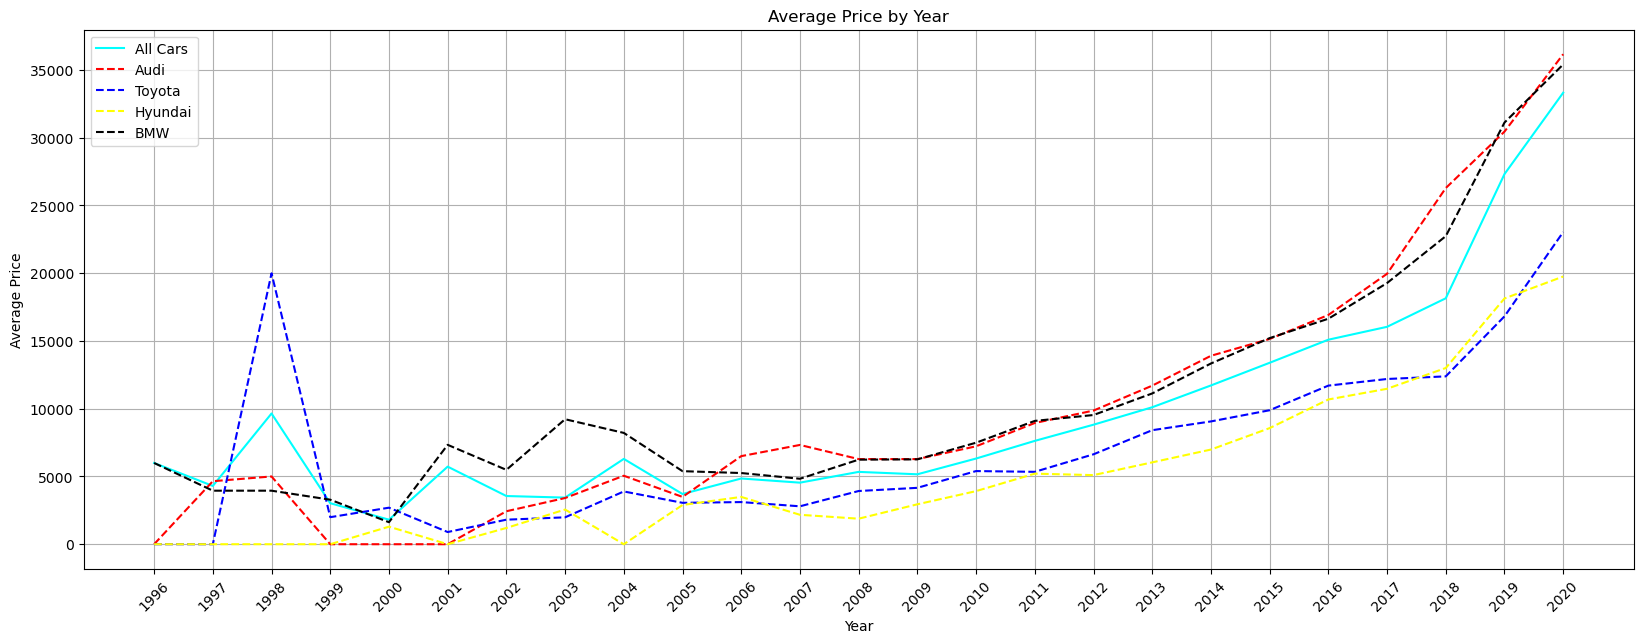

In [14]:
# group data tahun dan price berdasarkan tahun dan company denga filter setiap company
year = dataset[['year', 'price']].groupby('year').mean()
audi = dataset[['year', 'price']][dataset['company'] == "Audi"].groupby('year').mean()
toyota = dataset[['year', 'price']][dataset['company'] == "Toyota"].groupby('year').mean()
hyundai = dataset[['year', 'price']][dataset['company'] == "Hyundai"].groupby('year').mean()
bmw = dataset[['year', 'price']][dataset['company'] == "BMW"].groupby('year').mean()

# melakukan index ulang supaya range x sama
audi = audi.reindex(year.index, fill_value=0)
toyota = toyota.reindex(year.index, fill_value=0)
hyundai = hyundai.reindex(year.index, fill_value=0)
bmw = bmw.reindex(year.index, fill_value=0)


plt.figure(figsize=(20, 7))

# Plot rata-rata semua mobil pertahun dengan garis
plt.plot(year.index, year['price'], label='All Cars', linestyle='-', color='cyan')

# plot rata-rata per brand dengan warna garis yang berbeda
plt.plot(audi.index, audi['price'], label='Audi', linestyle='--', color='red')
plt.plot(toyota.index, toyota['price'], label='Toyota', linestyle='--', color='blue')
plt.plot(hyundai.index, hyundai['price'], label='Hyundai', linestyle='--', color='yellow')
plt.plot(bmw.index, bmw['price'], label='BMW', linestyle='--', color='black')

# modifikasi xticks
plt.xticks(year.index, labels=year.index, rotation=45)

# legend dengan posisi kiri atas
plt.legend(loc=2)

# title dan label
plt.title('Average Price by Year')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.grid(True)

plt.show()


Dari chart di atas, kita bisa melihat bahwa:
- Setiap perusahaan memiliki rata-rata yang berbeda dari tahun ke tahun. 
- Rata-rata harga pada semua perusahaan mengalami kenaikan yang mirip sebagaimana bertambahnya tahun. Ini menandakan semakin muda sebuah mobil, maka harga nya semakin tinggi.

##### 5. Rata-Rata Harga Per Company

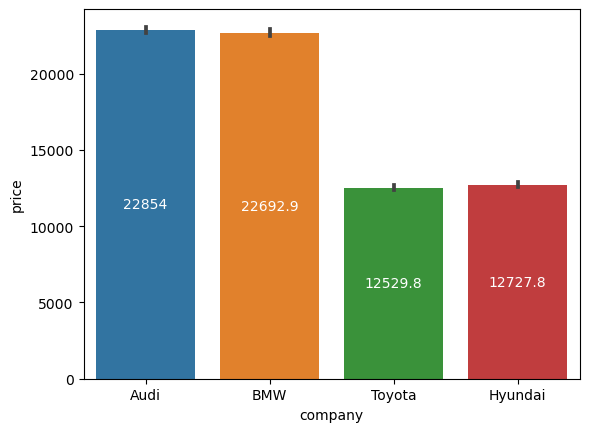

In [15]:
ax=sns.barplot(dataset, x='company', y='price', estimator='mean') # bar
plt.bar_label(ax.containers[0], label_type='center', color='white') # bar label
plt.show()

Terlihat bahwa company yang ada terbagi seperti terbagi menjadi 2 kelas. Kelas dengan rata-rata harga yang tinggi yaitu Audi dan BMW, lalu kelas dengan harga rata-rata yang rendah yaitu Toyota dan Hyundai. 

##### 6. Rata-Rata Harga per Model

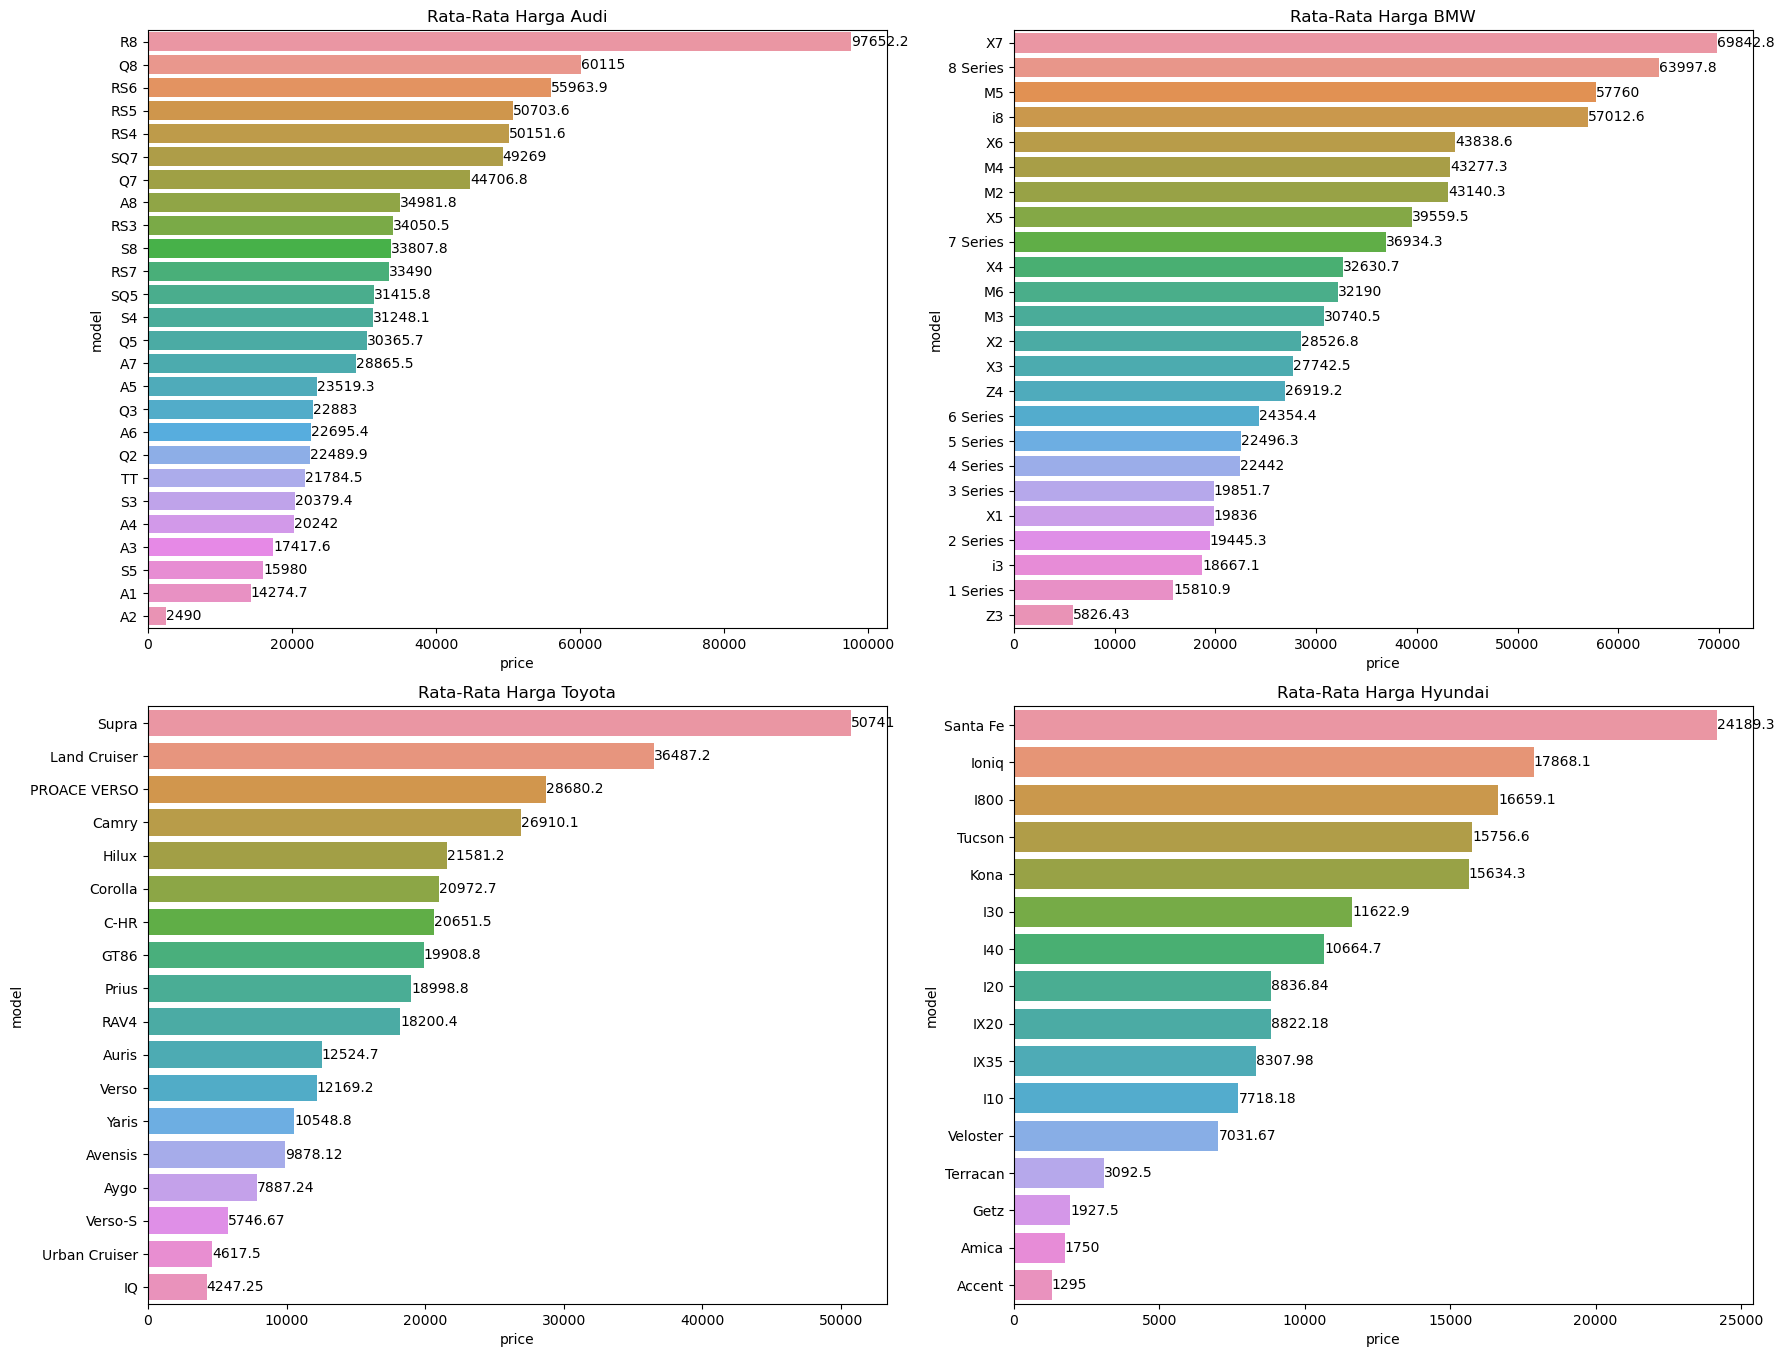

In [16]:
company = dataset['company'].unique().tolist() # list nama brand

plt.figure(figsize=(18,20))
for i, comp in enumerate(company):
    plt.subplot(3,2,i+1)
    data = dataset[['model','price']][dataset['company']==comp].groupby('model').mean().sort_values("price", ascending=False) #filter data berasarkan brand
    ax=sns.barplot(data, x='price', y=data.index) # barplot
    plt.bar_label(ax.containers[0]) # bar label
    plt.title(f"Rata-Rata Harga {comp}")
plt.tight_layout()

Kita bisa melihat bahwa setiap model dari setiap company memiliki harga rata-rata yang berbeda satu sama lain namun terdapat kemiripan antar model, hal ini akan digunakan sebagai tolak ukur pada proses pengurangan cardinality di feature engineering. 

##### 7. Perbadingan Harga rata-rata setiap Transmision

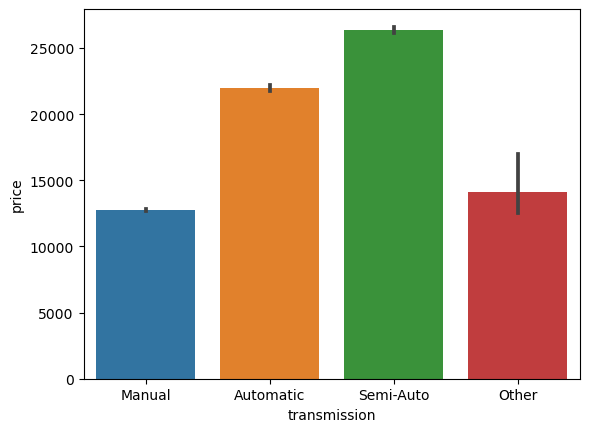

In [17]:
sns.barplot(dataset, x='transmission', y='price', estimator='mean') #bar label
plt.show()

Ketika melihat rata-rata harga setiap transmission, kita bisa lihat bahwa yang paling mahal justru adalah semi-auto, disusul automatic, lalu other, dan Manual. Ini bisa disebabkan oleh adanya outliers. Pada dunia nyata jika diurutkan dari yang termurah yaitu manual, semi-auto, automatic.

##### 8. Rata-Rata Efisiensi Bahan Bakar berdasarkan Brand

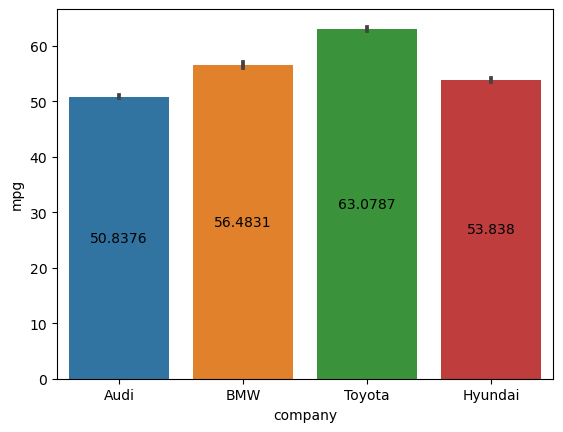

In [18]:
ax=sns.barplot(dataset, x='company', y='mpg', estimator='mean') #bar label
plt.bar_label(ax.containers[0], label_type='center')
plt.show()

Dari sini kita melihat bahwa Brand dengan efisiensi bahan bakar terbaik adalah Audi, disusul dengan Hyundai, BMW dan Toyota. Semakin kecil rata-rata efisiensi bahan bakar, semakin irit atau hemat konsumsi bahan bakar sebuah mobil.

##### 9. Efisiensi Konsumsi Bahan Bakar berdasarkan tipe Transmisi dan Ukuran Mesin

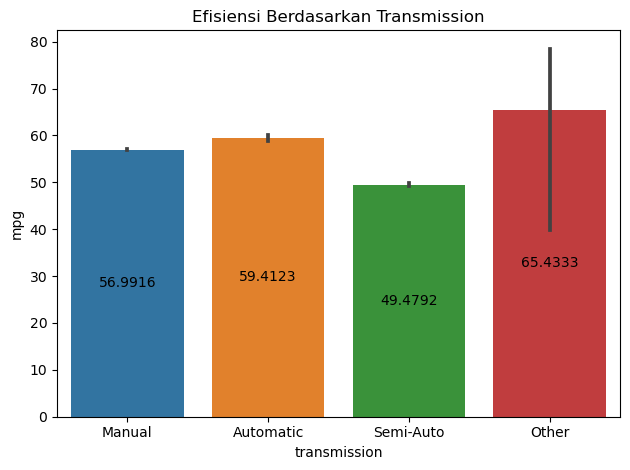

In [19]:
ax=sns.barplot(dataset, x='transmission', y='mpg', estimator='mean')  #bar plot
plt.bar_label(ax.containers[0], label_type='center') # bar label
plt.title(f"Efisiensi Berdasarkan Transmission") # judul
plt.tight_layout()

Disini kita bisa melihat bahwa Semi-Auto memiliki efisiensi yang paling baik di antara tipe transmissi lain. 

### **D. Feature Engineering**

##### Cardinality Checking

Cardinality check hanya dilakukan untuk kolom dengan categorical - nominal. Kolom yang bersifat ordinal tidak dilakukan pemeriksaan cardinality.

In [20]:
categorical_col = ['model', 'transmission', 'fuelType','company'] # list categorical
for col in categorical_col:
    print(col+": ",dataset[col].nunique())

model:  84
transmission:  4
fuelType:  5
company:  4


Dari kolom categorical yang bersifat nominal, hanya terdapat model dengan kardinalitas yang tinggi. Kolom model tidak akan dikurangi kardinalitasnya dengan alasan:
1. Telah dilakukan pre-eliminary testing dengan membandingkan hasil prediksi, cardinalitas kolom model yang tinggi apa ada nya justru memiliki kinerja lebih baik dibanding ketika kardinalitas nya dikurangi.
2. Kolom model diperlukan agar user bisa menggunakan aplikasi sesuai dengan tipe atau model yang dimiliki. 

##### 2. Data Split

In [21]:
# define x and y
X = dataset.drop('price', axis=1) 
y = dataset['price']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9)
print(f"Size data X train: {X_train.shape[0]} baris dan {X_train.shape[1]} kolom")
print(f"Size data y train: {y_train.shape[0]} baris")
print(f"Size data X test: {X_test.shape[0]} baris dan {X_test.shape[1]} kolom")
print(f"Size data y test: {y_test.shape[0]} baris")

Size data X train: 22891 baris dan 9 kolom
Size data y train: 22891 baris
Size data X test: 9811 baris dan 9 kolom
Size data y test: 9811 baris


##### 3. Outlier Handling

Visualisasi Outliers

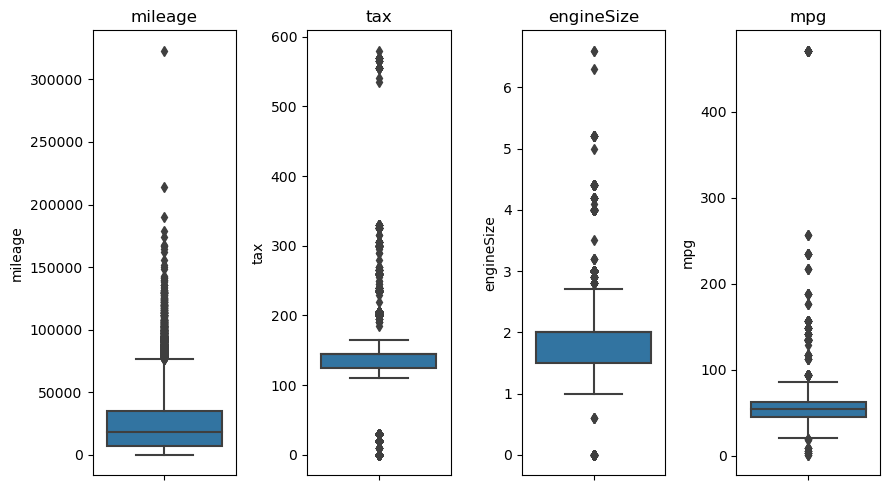

In [22]:
# seleksi kolom numerical
numerical_col = ['mileage','tax','engineSize','mpg'] 

plt.figure(figsize=(9,5))
for i, col in enumerate(numerical_col): 
    plt.subplot(1,4,i+1)
    sns.boxplot(X_train,y=col) # boxplot
    plt.title(col)
plt.tight_layout()

Terlihat outliers ditemukan pada semua kolom numerical. Keberadaan outliers ini akan cukup mengganggu akurasi dan kineraja model. Untuk itu perlu dilakukan penanganan khusus untuk outliers ini. Sebelum melakukan melakukan outlier handling, perlu dicek terlebih dahulu distribusi dari data numerical untuk memilih metode yang tepat.

In [23]:
X_train_num = X_train[numerical_col] # filter data numerical train
X_test_num = X_test[numerical_col] # filter data numerical test

In [24]:
def distribution_test(dataframe):
    '''
    Fungsi ini mengambil parameter sebuah dataframe yang akan periksa distribusi data per kolom nya. 
    '''
    # assing list untuk nama2 kolom yang memiliki skewness tertentu
    normal_dist_columns = [] # list container kolom normal
    skewed_dist_columns = [] # list container kolom skewed
    dataframe_columns = dataframe.columns.tolist() # list kolom yang ada dalam dataframe
    for column in dataframe_columns:
        skewness = dataframe[column].skew()
        # jika skewness di antara -0.5 dan 0.5 maka distribusi normal atau mendekati normal
        if skewness > 0.5 or skewness < -0.5:
            skewed_dist_columns.append(column)
        # jika tidak, maka data memiliki skewness negatif atau positive moderate atau extreme
        else:
            normal_dist_columns.append(column)

    # cetak output
    print(f"berikut data kolom yang memiliki normal distribution:")
    print(normal_dist_columns)
    print(f"Kolom yang memiliki skewed distribution:")
    print(skewed_dist_columns)

    # buat dataframe untuk dijadikan output

    return normal_dist_columns, skewed_dist_columns

In [25]:
# panggil fungsi di atas
normal, skewed = distribution_test(X_train_num)

berikut data kolom yang memiliki normal distribution:
['tax']
Kolom yang memiliki skewed distribution:
['mileage', 'engineSize', 'mpg']


Hanya terdapat kolom tax yang bersifat normal. Metode capping and censoring akan dilakukan untuk menjaga keutuhan data. Untuk kolom dengan distribusi normal, akan dilakukan capping dengan metode Gaussian, sedangkan untuk kolom yang tidak memiliki distribusi normal akan dilakukan capping dengan metode IQR.

Normal Distribution - Gaussian  Capping Method

In [26]:
winsor = Winsorizer(capping_method='gaussian', tail='both',fold=3, variables=normal,missing_values='ignore') # winsorizer normal distribution

X_train_num_capped = winsor.fit_transform(X_train_num)
X_test_num_capped = winsor.transform(X_test_num)

Skewed Distribution - IQR Capping Method

In [27]:
winsor_skew = Winsorizer(capping_method='iqr', tail='both',fold=1.5, variables=skewed,missing_values='ignore') # winsorizer skewed distribution

X_train_num_capped = winsor_skew.fit_transform(X_train_num_capped)
X_test_num_capped = winsor_skew.transform(X_test_num_capped)

Visualisasi Outliers Setelah Capping

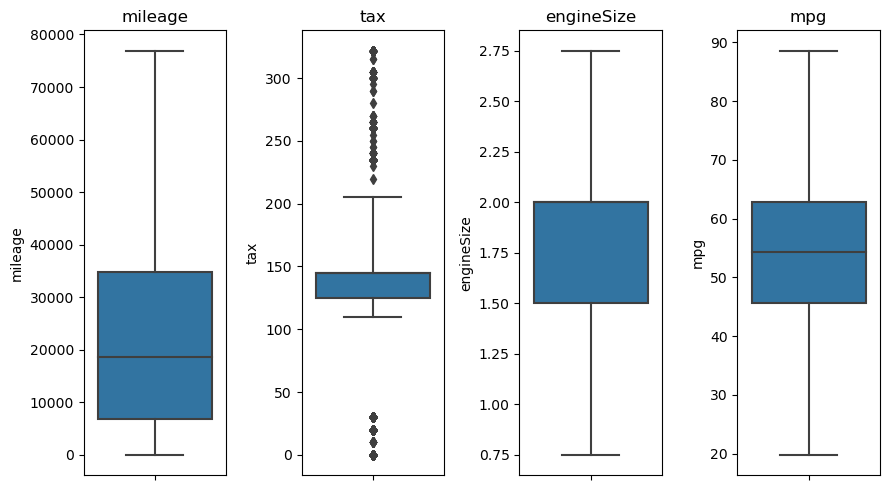

In [28]:
# seleksi kolom numerical
numerical_col = ['mileage','tax','engineSize','mpg']

plt.figure(figsize=(9,5))
for i, col in enumerate(numerical_col):
    plt.subplot(1,4,i+1) #subplot
    sns.boxplot(X_train_num_capped,y=col,whis=3) # boxplot
    plt.title(col)
plt.tight_layout()

Outliers sudah dihandling, namun pada tax terlihat masih ada beberapa titik outliers meskipun range data telah berubah. Hal ini bisa disebabkan oleh metode capping yang berbeda.

In [29]:
# menggabungkan kembali train dan test data.,'class'
X_train_cat = X_train[['year','transmission','fuelType','model','company']]
X_test_cat = X_test[['year','transmission','fuelType','model','company']]

# gabung data numerik dan categorikal
X_train_capped = pd.concat([X_train_num_capped, X_train_cat], axis=1)
X_test_capped = pd.concat([X_test_num_capped, X_test_cat], axis=1)

##### 4. Missing Value 

Tidak terdapat missing value pada data

##### 5. Feature Selection

Untuk memilih fitur-fitur atau kolom yang memang secara statistik diperlukan, harus dilakukan pemilihan dengan menggunakan metode statistik juga. Data pada kasus ini terdiri dari numerical dan categorical data. Kedua jenis data tersebut akan diseleksi dengan cara yang berbeda. Untuk numerical data akan dilakukan metode perhitungan nilai korelasi sedangkan categorical data akan dihitung dengan mencari nilai p value dengan menggunakan Anova Test.

***Numerical column***<br>
Sebelum melakukan nilai korelasi, distribusi data kolom kembali dicek terlebih dahulu

In [30]:
normal, skewed = distribution_test(X_train_num_capped) # panggil fugsi cek distribusi

berikut data kolom yang memiliki normal distribution:
['tax', 'engineSize', 'mpg']
Kolom yang memiliki skewed distribution:
['mileage']


Terlihat bahwa setelah dicapping hanya kolom mileage yang memiliki distribusi tidak normal.
- Pearson correlation akan digunakan untuk kolom dengan normal distribution.
- Spearman correlation akan digunakan untuk kolom dengan skewed distribution.

Normal Distribution Heatmap

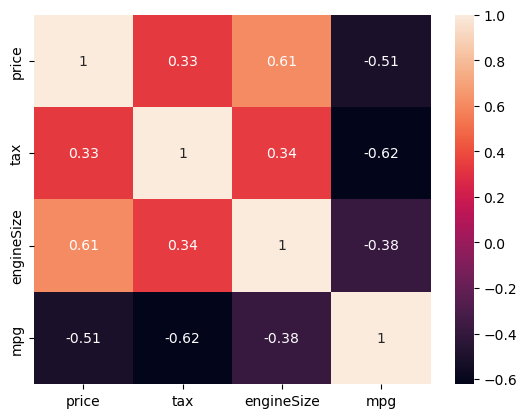

In [31]:
normal = X_train_capped[normal] # normal distribution
normal.insert(loc=0, column='price', value=y_train) # masukan price
sns.heatmap(normal.corr('pearson'), annot=True) # pearson correlation heatmap
plt.show()

- Hanya tax yang memiliki korelasi yang lemah terhadap price dibanding variable lain. Untuk itu tax tidak akan diikutsertakan.
- Yang dipilih pada kolom numerical dengan distribusi normal adalah: engineSize dan mpg

Skewed Distribution Heatmap

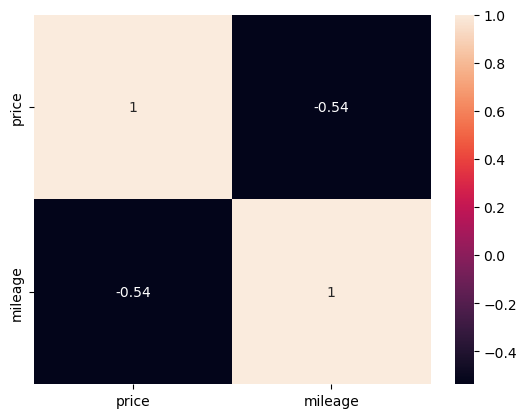

In [32]:
skewed = X_train_capped[skewed] #filter skewed
skewed.insert(loc=0, column='price', value=y_train)
sns.heatmap(skewed.corr('spearman'), annot=True) # spearman correlation heatmap
plt.show()

Kolom mileage memiliki spearman correlation negatif yang cukup kuat, untuk itu akan dikutsertakan.

***Categorical Column***

Untuk mengetahui nilai korelasi antara variable categorical terhadap numerical value, dilakukan ANOVA test. Berikut hypothesis untuk test:

>H0 = Tidak terdapat korelasi yang signifikan antara 'x' categorical data dengan price<br>
>H1 = Terdapat korelasi yang signifikan antara 'x' categorical data dengan price

Jika p value lebih rendah dari significance level 0.05 -> H0 ditolak, H1 diterima.<br>
Jika p value lebih tinggi dari significance level 0.05 -> H0 diterima, H1 ditolak

In [33]:
def anova_test(dataframe):
    '''
    fungsi ini mengambil sebuah parameter berupa dataframe untuk kemudian nanti dihitung anova test nya.
    '''
    # nama kolom
    column_name = dataframe.columns.tolist()

    # list array yang digrouping setiap categori dalam satu kolom
    grouped_list_variables = []
    for category in dataframe[column_name[0]].unique():
        # variable data berisi array setiap numeric variable untuk setiap kategori pada kolom target, filter berdasarkan kategori kolom target (0 atau 1)
        variabel_data = dataframe['price'][dataframe[column_name[0]] == category]
        grouped_list_variables.append(variabel_data)

    # uji anova
    result = f_oneway(*grouped_list_variables)
    
    # pengambilan nama variable/kolom
    name_of_variable = dataframe.columns.tolist()[0]
    print(f"\nKolom {name_of_variable}:" )
    print(f"Nilai statistic = {result.statistic}")
    print(f"p_value = {result.pvalue}")
    if result.pvalue < 0.05:
        print(f'--> P_value lebih rendah dari 0.05, {name_of_variable} dipilih')
    print("=="*40)

In [34]:
set = X_train_capped.select_dtypes('object') # atur categorical 
set['year']=X_train_capped['year'] # masukan tahun

vars = set.columns.tolist() # list kolom

set.insert(loc=0, column='price', value=y_train) # masukan price ke dataset set

for var in vars: # looping
    data = set[[var, 'price']]
    anova_test(data)



Kolom transmission:
Nilai statistic = 2928.729426463286
p_value = 0.0
--> P_value lebih rendah dari 0.05, transmission dipilih

Kolom fuelType:
Nilai statistic = 182.22013812806279
p_value = 5.5329546280315035e-154
--> P_value lebih rendah dari 0.05, fuelType dipilih

Kolom model:
Nilai statistic = 452.0105050868124
p_value = 0.0
--> P_value lebih rendah dari 0.05, model dipilih

Kolom company:
Nilai statistic = 1796.385970742067
p_value = 0.0
--> P_value lebih rendah dari 0.05, company dipilih

Kolom year:
Nilai statistic = 539.9638293019394
p_value = 0.0
--> P_value lebih rendah dari 0.05, year dipilih


Semua kolom categorical memiliki nilai p_value yang lebih rendah dari 0.05, sehingga semua kolom dipilih.

**Hasil Feature Selection**<br>
Dari proses feature selection data numerical dan categorical, berikut features yang akan dimasukan ke dalam model:
1. `year` = Tahun pembuatan mobil (categorical - ordinal)
2. `transmission` = Tipe transmisi mobil (categorical - nominal)
3. `mileage` = Jumlah jarak tempuh dalam miles (numerical)
4. `fuelType` = Jenis bahan bakar (cateogrical - nominal)
5. `mpg`= Miles per Galnon (1 gallon = 3.78541 liter - numerical) 
6. `engineSize` = Ukuran mesin (Numerical)
7. `model` = tipe atau model mobil
8. `company` = Car manufacturer/brand

Insights:
1. Harga mobil bekas bisa dipengaruhi oleh beberapa hal seperti merek, tipe mobil, tipe transmisi, tahun pembuatan, jarak tempuh, jenis bahan bakar, ukuran mesin, bahkan efisiensi bahan bakar. 
2. Secara umum, setiap merek atau tipe mobil memang mempengaruhi harga mobil. Semakin besar atau premium sebuah brand, biasanya harga semakin mahal.
3. Tahun dan total jarak tempuh juga sering kali digunakan sebagai salah satu tolak ukur dalam menentukan harga mobil. Semakin muda atau semakin sedikit jarak tempuh, maka mobil semakin mahal. 
4. Jenis bahan bakar dan efisiensi bahan bakar termasuk salah satu hal yang harus diperhatikan dalam menentukan harga mobil karena tiap jenis bahan bakar memiliki harga yang berbeda, dan mobil dengan konsumsi bahan bakar yang rendah cenderung lebih diminati. 
5. Jenis transmisi dan ukuran mesin juga mempengaruhi harga mobil. Dalam hal ini, sudah menjadi standard tersendiri bahwa mobil dengan transmisi automatic lebih mahal karena mobil biasanya lebih praktis dan lebih mudah dioperasikan. Sedangkan ukuran mesin biasanya menandakan tenaga atau performa mesin, semakin besar ukuran mesin, tenaga yang dihasilkan pun semakin besar. Kedua hal tersebut mempengaruhi harga. 

In [35]:
X_train_selected = X_train_capped[['year','transmission','mileage','fuelType','engineSize','mpg','model','company']] # seleksi fitur terpilih
X_test_selected = X_test_capped[['year','transmission','mileage','fuelType','engineSize','mpg','model','company']]

##### 6. Scaling and Encoding

Untuk data X_train baik yang bersifat categorical dan numeric, nilai harus disesuaikan dengan skala atau standard nilai yang sama. Untuk data numeric, harus dilakukan scaling untuk menyamakan range nilai antar variable. Sedangkan untuk categorical data, dilakukan encoding untuk mempermudah model mempelajari data. 

In [36]:
# define categorical and numerical columns
num_col = ['mileage', 'engineSize','mpg']
cat_col = ['year','fuelType','transmission','model','company']

**Scaling - Numerical Data**

Untuk scaling, kita akan sesuaikan dengan distribusi data.

In [37]:
X_train_selected_num = X_train_capped[num_col] # seleksi data numerik train
X_test_selected_num = X_test_selected[num_col] # seleksi data numerik test

normal, skewed = distribution_test(X_test_selected_num) # cek distribusi

berikut data kolom yang memiliki normal distribution:
['engineSize', 'mpg']
Kolom yang memiliki skewed distribution:
['mileage']


Metode yang dipilih untuk scaling data numeric adalah **MinMaxScaler** dengan alasan:
1. Terdapat keragaman distribusi data. Terdapat variable dengan normal distribution dan skewed. Sehingga minmaxscaler menjadi metode yang cocok dengan data yang ada karena metode ini tidak memperhatikan distribusi data. 
2. Minmaxscaler memiliki kelemahan yaitu sensitif terhadap outliers. Data yang ada sudah terbebas dari outliers sehingga menggunakan metode ini sudah tepat. 
3. MinMaxscaler juga lebih menjaga keutuhan representasi data yang tentunya bisa menghindari adanya distrosi pada data setelah scaling. 

In [38]:
scaler = MinMaxScaler() # define minmax scaler

# fit dan transform ke numerical data
X_train_num_scaled = scaler.fit_transform(X_train_selected_num)
X_test_num_scaled = scaler.transform(X_test_selected_num)

**Encoding**

Pada bagian encoding, categorical dengan jenis ordinal akan diberlakukan ordinal encoder, sedangkan categorical yang berjenis nominal akan diberlakukan one hot encoding.

In [39]:
X_train_selected_cat = X_train_selected[cat_col] #filter categoriccal data train
X_test_selected_cat = X_test_selected[cat_col] #filter categoriccal data test
 
X_train_selected_cat.columns.tolist() # utk menampilkan isi kolom

['year', 'fuelType', 'transmission', 'model', 'company']

- `year` dan `transmission` merupakan categorical yang bersifat ordinal, diterapkan ordinal encoding.
- `fuelType` dan `model` termasuk ke dalam nominal, sehingga dilakukan one-hot encoding.

*Ordinal Encoder*

In [40]:
ordinal = ['year','transmission']

# filter ordinal cat train dan tezt
ordinal_train = X_train_selected_cat[ordinal]
ordinal_test = X_test_selected_cat[ordinal]

#Category encoder year dan transmisi
year_cat = [int(x) for x in range(1996,2022,1)]
transmission_cat = ['Other','Manual','Semi-Auto','Automatic' ]

#encoder
ordinal_encoder = OrdinalEncoder(categories=[year_cat,
                                             transmission_cat])
#fit and transform
X_train_ordinal = ordinal_encoder.fit_transform(ordinal_train)
X_test_ordinal = ordinal_encoder.transform(ordinal_test)

*One-Hot Encoding*

In [41]:
nominal = ['fuelType','model', 'company'] # list nominal categorical data

#filter nominal cat
nominal_train = X_train_selected_cat[nominal]
nominal_test = X_test_selected_cat[nominal]

# encoder
hot_encoder = OneHotEncoder()

# fit transform
X_train_nominal = hot_encoder.fit_transform(nominal_train).toarray()
X_test_nominal = hot_encoder.transform(nominal_test).toarray()

Menggabungkan X_train dan X_test hasil scaling dan encoding

In [42]:
X_train_final = np.concatenate([X_train_num_scaled,X_train_ordinal,X_train_nominal],axis=1) # gabung train data
X_test_final = np.concatenate([X_test_num_scaled, X_test_ordinal,X_test_nominal],axis=1) # gabung test data

### **E. Model Definition**

Pada bagian ini, dilakukan definisi model baseline dari setiap ML model. Untuk Random forest dan Decision tree diberikan random state supaya kondisi tidak berubah

In [43]:
# model default setiap ML model
knn = KNeighborsRegressor()
svr = SVR()
randomForest = RandomForestRegressor(random_state = 17)
decisionTree = DecisionTreeRegressor(random_state = 17)

# Ada boosting menggunakan decision tree base bodel
ada = AdaBoostRegressor(DecisionTreeRegressor(), random_state=15)

### **F. Model Training**

Pada bagian ini dilakukan model training untuk hyperparameter default, cross_validation dan boosting. 

In [44]:
knn_model = knn.fit(X_train_final, y_train)
svr_model = svr.fit(X_train_final, y_train)
rf_model = randomForest.fit(X_train_final, y_train)
dt_model = decisionTree.fit(X_train_final, y_train)

# adaboost using AdaBoost Regressor
ada_model = ada.fit(X_train_final, y_train)

Predictions

In [45]:
# knn model
y_pred_train_knn = knn_model.predict(X_train_final)
y_pred_test_knn = knn_model.predict(X_test_final)

# svr model
y_pred_train_svr = svr_model.predict(X_train_final)
y_pred_test_svr = svr_model.predict(X_test_final)

# random forest
y_pred_train_rf = rf_model.predict(X_train_final)
y_pred_test_rf = rf_model.predict(X_test_final)

# decision Tree
y_pred_train_dt = dt_model.predict(X_train_final)
y_pred_test_dt = dt_model.predict(X_test_final)

# adaboost
y_pred_train_ada = ada_model.predict(X_train_final)
y_pred_test_ada = ada_model.predict(X_test_final)

Reports

In [46]:
def report(y_train, y_pred_train, y_test, y_pred_test):
  '''
  fungsi menggambil data train dan test lalu direturn sebagai satu series
  '''
  # buat dictionary
  reports = {
      'Train - MAE' : mean_absolute_error(y_train, y_pred_train), 
      'Train - MSE' : mean_squared_error(y_train, y_pred_train),
      'Train - RMSE' : mean_squared_error(y_train, y_pred_train, squared=False),
      'Train - R2-Score' : r2_score(y_train, y_pred_train),
      'Test - MAE' : mean_absolute_error(y_test, y_pred_test),
      'Test - MSE' : mean_squared_error(y_test, y_pred_test),
      'Test - RMSE' : mean_squared_error(y_test, y_pred_test, squared=False),
      'Test - R2-Score' : r2_score(y_test, y_pred_test),
  }
  
  return reports

In [47]:
pd.options.display.float_format = '{:,.3f}'.format #atur format angka pada dataframe
reports = pd.DataFrame() #buat dataframe baru

# generate hasil report
reports['KNN'] = report(y_train, y_pred_train_knn, y_test, y_pred_test_knn)
reports['SVR'] = report(y_train, y_pred_train_svr, y_test, y_pred_test_svr)
reports['RF'] = report(y_train, y_pred_train_rf, y_test, y_pred_test_rf)
reports['DT'] = report(y_train, y_pred_train_dt, y_test, y_pred_test_dt)
reports['ADA'] = report(y_train, y_pred_train_ada, y_test, y_pred_test_ada)
reports # tampilkan report

,KNN,SVR,RF,DT,ADA
Train - MAE,"1,202.433","7,772.531",513.037,32.668,284.424
Train - MSE,"4,573,205.620","125,031,487.004","852,816.519","71,554.631","402,738.888"
Train - RMSE,"2,138.505","11,181.748",923.481,267.497,634.617
Train - R2-Score,0.963,-0.018,0.993,0.999,0.997
Test - MAE,"1,516.298","7,853.163","1,342.623","1,688.573","1,388.171"
Test - MSE,"6,466,283.018","129,500,532.394","4,435,632.973","8,821,258.835","4,818,827.143"
Test - RMSE,"2,542.889","11,379.830","2,106.094","2,970.060","2,195.183"
Test - R2-Score,0.949,-0.020,0.965,0.931,0.962


Interpretasi:<br>

**MAE**<br>
MAE menunjukan rata-rata selisih absolut dari hasil prediksi dan nilai sesungguhnya. Nilai MAE pada setiap model berbeda-beda baik train ataupun test score. Terlihat dari table untuk train data, Nilai MAE dari Decision Tree paling baik dengan nilai MAE terendah. Sedangkan untuk data test, Nilai MAE random forest paling baik dengan nilai MAE yang palling rendah. Perbedaan MAE test data untuk Decision Tree dan Random Forest sebenarnya tidak terlalu jauh.

**MSE - Mean Squared Error**<br>
MSE adalah nilai kuadrat dari rata-rata selisih hasil predikksi dan nilai aktual. Setiap model memiliki nilai MSE yang berbeda-beda dengan nilai yang beragam dari rentang ratusan ribu hingga ratusan juta. Kita bisa lihat disini, nilai MSE yang paling baik untuk data train dipegang oleh Decision Tree. Sedangkan untuk data test nilai MSE paling baik dipegang oleh AdaBoost dengan base model decision tree.

**RMSE - Root Mean Squared Error**<br>
RMSE adalah nilai akar kuadrat dari MSE yang dalam kasus ini, setiap model memiliki nilai yang beragam. Untuk data train, nilai RMSE yang paling baik ada pada model Decision Tree. Sedangkan untuk data test ada pada Random Forest dengan selisih yang tidak terlalu jauh dengan ADA boost.

**R2 Score**<br>
Nilai R2 Score menunjukan seberapa hasil model dalam merepresentasikan data asli. Untuk Data train, R2 score paling tinggi ada pada Ada boost base model Decision Tree dan untuk data Test lagi lagi ada pada Random Forest.

> Dengan melihat pola yang ada, random forest dengan cukup baik mengalahkan performa model lain pada test data. Sedangkan untuk model decision tree default hanya menunjukan performa yang baik pada train data dan menunjukan kinerja yang lemah pada test data. AdaBoost masih lebih baik pada test data dibanding dengan decision tree.

Dengan pertimbangan score terbaik pada train dan test data, model decision tree sangat baik pada train data dan random forest sangat baik pada test data. Untuk itu, akan dilakukan cross validation pada kedua model yaitu Decision tree default dan random forest.

**Cross Validation**

Disini, dilakukan cross validation dengan value cv=10, sehingga iterasi dilakukan sebanyak 10 kali yang menghasilkan 10 score yang berbeda setiap kali iterasi. 

In [48]:
# cross validation train data
DT_cv_score_tr = cross_val_score(estimator=dt_model, X=X_train_final, y=y_train, cv=10, n_jobs=-1)
RF_cv_score_tr = cross_val_score(estimator=rf_model, X=X_train_final, y=y_train, cv=10, n_jobs=-1)
# cross validation test data
DT_cv_score_ts = cross_val_score(estimator=dt_model, X=X_test_final, y=y_test, cv=10, n_jobs=-1)
RF_cv_score_ts = cross_val_score(estimator=rf_model, X=X_test_final, y=y_test, cv=10, n_jobs=-1)

print("Train Data")
print("Cross Validation - Decision Tree")
print("std: ",DT_cv_score_tr.std())
print("mean: ",DT_cv_score_tr.mean())

print("\nCross Validation - Random Forest")
print("std: ",RF_cv_score_tr.std())
print("mean: ",RF_cv_score_tr.mean())

print("\nTest Data")
print("Cross Validation - Decision Tree")
print("std: ",DT_cv_score_ts.std())
print("mean: ",DT_cv_score_ts.mean())

print("\nCross Validation - Random Forest")
print("std: ",RF_cv_score_ts.std())
print("mean: ",RF_cv_score_ts.mean())


Train Data
Cross Validation - Decision Tree
std:  0.03515573341344857
mean:  0.9137297959801064

Cross Validation - Random Forest
std:  0.012075443099560938
mean:  0.9526568417783414

Test Data
Cross Validation - Decision Tree
std:  0.012248947849526196
mean:  0.9261887831979969

Cross Validation - Random Forest
std:  0.007834640584967086
mean:  0.955185360650157


Hasil dari Cross Validation memberikan gambaran tentang seberapa baik model Decision Tree (DT) dan Random Forest (RF) berkinerja pada data pelatihan (Train Data) dan data pengujian (Test Data) dengan rincian sebagai berikut:

Train Data:

- Decision Tree (DT): Standar deviasi (std) hasil Cross Validation sekitar 0.035, dan rata-rata (mean) sekitar 0.914. Standar deviasi yang rendah menunjukkan konsistensi dalam performa model, dan rata-rata yang tinggi menunjukkan bahwa model Decision Tree cenderung memberikan prediksi yang baik pada data train.<br>
- Random Forest (RF): Standar deviasi hasil Cross Validation sekitar 0.012, dan rata-rata sekitar 0.953. Hasil ini menunjukkan bahwa Random Forest memiliki performa yang lebih baik daripada Decision Tree pada data train, dengan standar deviasi yang lebih rendah dan rata-rata yang lebih tinggi.

Test Data:

- Decision Tree (DT): Standar deviasi hasil Cross Validation sekitar 0.012, dan rata-rata sekitar 0.926. Hasil ini menunjukkan bahwa model Decision Tree juga memiliki performa yang baik pada data test, meskipun sedikit lebih rendah dibandingkan dengan data train. Disini terlihat ada indikasi overfitting pada Decision Tree. <br>
- Random Forest (RF): Standar deviasi hasil Cross Validation sekitar 0.008, dan rata-rata sekitar 0.955. Random Forest tetap memiliki performa yang sangat baik pada data test, bahkan menunjukan hasil yang lebih baik dibandingkan dengan data train hasil RF sendiri.

Secara keseluruhan, hasil Cross Validation menunjukkan bahwa model Random Forest cenderung memberikan hasil yang lebih baik daripada model Decision Tree, baik pada data train maupun data test. Ini mengindikasikan bahwa Random Forest memiliki kemampuan yang lebih baik dalam generalisasi dan memiliki kinerja yang lebih baik untuk menghindari overfitting.

Dengan demikian, kita akan melanjutkan dengan Random Forest sebagai model yang digunakan dan akan dilakukan hyperparameter tuning untuk mencari parameter terbaik dengan gridserach. 

#### **G. Hyperparameter Tuning and Model Evaluation**

Pada bagian ini, akan dilakukan random dan  grid search untuk mencari parameter terbaik pada model Random Forest.

In [49]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 17,
 'verbose': 0,
 'warm_start': False}

Dari hyperparameters di atas, kita akan mencoba mencari kombinasi terbaik dengan mengatur beberapa hyperparameter seperti max_depth, min_samples_leaf, max_leaf_nodes, dan min_samples_split. 

**Random Search**

Pada random search, akan diberikan rentang nilai untuk setiap hyperparameter. Tidak setiap nilai akan dicoba oleh model random search, untuk itu range angka bisa sedikit lebih banyak.

In [50]:
# list max depth
max_depth = [int(x) for x in range(2, 20)]

# min samples leaf
min_samples_leaf =[int(x) for x in range(1, 20)]

# max leaf nodes
max_leaf_nodes = [int(x) for x in range(1, 20)]

# lmin samples split
min_samples_split = [int(x) for x in range(2, 20)]

# parameter random
rf_random_params = {'max_depth':max_depth,
                    'min_samples_leaf':min_samples_leaf,
                    'max_leaf_nodes':max_leaf_nodes,
                    'min_samples_split':min_samples_split
                        }
# random search
rf_random_search = RandomizedSearchCV(estimator=RandomForestRegressor(),
                                       param_distributions=rf_random_params,
                                       cv=5,
                                       random_state=17,
                                       n_jobs=-1,
                                       scoring='r2')

In [51]:
# fit data
rf_random_search.fit(X_train_final,y_train)
rf_random_search.best_estimator_

RandomForestRegressor(max_depth=11, max_leaf_nodes=19, min_samples_leaf=7,
                      min_samples_split=9)

**Grid Search**<br>
Dari hasil random search kita mendapatkan value terbaik untuk setiap hyperparameter. Dari hasil itu, Grid search dilakukan untuk mencari value sekitar hasil best estimator random search.

In [52]:
rf_gs_params= { 'max_depth':[10,11,12], # value sekitar random search best params
                'min_samples_leaf':[6,7,8], # value sekitar random search best params
                'max_leaf_nodes':[18,19,20], # value sekitar random search best params
                'min_samples_split':[8,9,10] # value sekitar random search best params
                        }
# adjust gridsearch
grid_rf = GridSearchCV(estimator=RandomForestRegressor(),
                       param_grid=rf_gs_params,
                       cv=3,
                       n_jobs=-1,
                       scoring='neg_mean_absolute_error')


In [53]:
rf_grid_search = grid_rf.fit(X_train_final, y_train) #train gridsearch
rf_grid_search.best_estimator_

RandomForestRegressor(max_depth=10, max_leaf_nodes=20, min_samples_leaf=6,
                      min_samples_split=8)

Kita sudah mendapatkan best estimator dari grid serach dan random search di atas. Selanjutnya akan dilakukan prediksi dan hasil score.

**Hyperparameter Tuning Results**

In [54]:
rf_random_best = rf_random_search.best_estimator_
rf_grid_best = rf_grid_search.best_estimator_

# random search predict
y_pred_test_random = rf_random_best.predict(X_test_final)
y_pred_train_random = rf_random_best.predict(X_train_final)

# grid search predict
y_pred_test_grid = rf_grid_best.predict(X_test_final)
y_pred_train_grid = rf_grid_best.predict(X_train_final)

In [55]:
#generate report
RF_report = pd.DataFrame()
RF_report['RF Def'] = reports['RF']
RF_report['RF Grid'] = report(y_train, y_pred_train_grid, y_test, y_pred_test_grid)
RF_report['RF Random'] = report(y_train, y_pred_train_random, y_test, y_pred_test_random)
RF_report

,RF Def,RF Grid,RF Random
Train - MAE,513.037,"3,201.090","3,239.923"
Train - MSE,"852,816.519","21,296,247.721","22,059,879.489"
Train - RMSE,923.481,"4,614.786","4,696.795"
Train - R2-Score,0.993,0.827,0.820
Test - MAE,"1,342.623","3,232.625","3,272.628"
Test - MSE,"4,435,632.973","20,922,320.882","21,615,779.003"
Test - RMSE,"2,106.094","4,574.092","4,649.277"
Test - R2-Score,0.965,0.835,0.830


In [56]:
# Rata-rata harga seluruh mobil
print("Rata-Rata Harga mobil =",dataset['price'].mean())

# persentase error pada test data dengan model default
print("Persentase error harga(%) =",(1342.623/dataset['price'].mean())*100)

Rata-Rata Harga mobil = 19208.26545777017
Persentase error harga(%) = 6.989819059674018


Interpretasi:
- Grid search sedikit menunjukan peningkatan dari Random Search. Score yang didapat RF Grid lebih baik dibanding RF Random untuk semua score baik untuk train ataupun test data.
- Namun, Hasil Grid search dan Random Search tidak lebih baik dari RF default parameter ditandai dengan semua score yang lebih buruk dari model default. 
- Untuk itu **Random Forest Default** akan dipakai untuk deployment dengan alasan:
    - Metric utama yang dipakai yaitu MAE dan R2 Score.  
    - MAE untuk Train dan Test menunjukan 513 dan 1,342.623, artinya rata-rata selisih error antara hasil prediksi dan nilai aktual cukup rendah. Ketika kita ubah ke nilai mata uang Rupiah untuk train data error sekitar Rp. 9,835,666.73 dan untuk test data berkisar sekitar Rp. 25,741,895.46 yang cukup bisa ditoleransi ketika berbicara tentang harga sebuah mobil bekas. 
    - Sedangkan R2 score menunjukan angka yang cukup tinggi untuk train dan test data, yang mana lebih dari 94% representasi data aktual bisa dihasilkan dari hasil prediksi. Meskipun sedikit menunjukan adanya overfitting, namun perbedaan test dan train data tidak signifikan. 
    - Berdasarkan domain knowlegdge pribadi, error sebesar 6.9% untuk selisih harga prediksi dan nilai aktual tidak terlalu problematik. Untuk itu, model sudah bekerja dengan cukup baik.

**Tantangan dan Kelemahan Model**
- Model gridsearch dan random search memiliki runtime yang terlalu lama, sehingga untuk eskplorasi nilai-nilai lain tidak dilakukan. Hal ini membuat hasil dari gridsearch dan random search tidak menunjukan perbaikan dari model random forest dengan base model. 
- Sebagai catatan untuk **further development** bisa dicoba untuk mengurangi cardinalitas kolom 'model' dan tetap dilakukan one-hot encoder. Lalu hasil bisa dibandingkan dan lihat apabila ada peningkatan pada model. Ini mungkin bisa membuat runtime gridsearch dan random search tidak terlalu lama sehingga bisa mengeksplorasi lebih banyak nilai hyperparameter.

### **H. Model Saving**

Preprocessing and Model

In [57]:
# scaler
joblib.dump(scaler, 'deployment/scaler.pkl')

# encoder
joblib.dump(ordinal_encoder, 'deployment/ord_encoder.pkl')
joblib.dump(hot_encoder, 'deployment/hot_encoder.pkl')

# ML model
joblib.dump(rf_model, 'deployment/rf_model.pkl')

# Dataset untuk deployment
dataset.to_csv("deployment/dataset.csv", index=False)

Pipelines

In [58]:
# list berdasarkan tipe data
num_col = ['mileage', 'engineSize','mpg']
cat_ord = ['year','transmission']
cat_nom = ['fuelType','model','company']


# load scaler, encoder dan model 
scaler_num = joblib.load('deployment/scaler.pkl')
hot_enc = joblib.load('deployment/hot_encoder.pkl')
ord_enc = joblib.load('deployment/ord_encoder.pkl')
rf_mod = joblib.load('deployment/rf_model.pkl').fit(X_train_final, y_train)


# membuat transformer kolom
# scaler
numerical_transformer = Pipeline([
    ('scaler', scaler_num)])

# encoder ordinal
ordinal_transformer = Pipeline([
    ('ordinal_encoder', ord_enc)])
# hot encoder trnsformer
hot_transformer = Pipeline([
    ('hot_encoder', hot_enc) ])

# mengkombinasikan scaler dan encoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_col),
        ('ord_encoder', ordinal_transformer, cat_ord),
        ('hot_encoder', hot_enc, cat_nom)])
# fit prepocessor
fit_prepocessor = preprocessor.fit(X_train_selected)

# buat pipeline final dengan menggunakan preprocessing dan model
pipelines = Pipeline([
    ('preprocessor', fit_prepocessor),
    ('regressor', rf_model)
])

Saving Pipelines

In [59]:
joblib.dump(pipelines, "deployment/pipelines.pkl")

['deployment/pipelines.pkl']

### **I. Model Inference**

Pada notebook inference

### **J. Kesimpulan**

**Businees Domain**

Harga mobil bekas sangat dipengaruhi oleh berbagai faktor seperti merek, tipe mobil, tipe transmisi, tahun pembuatan, jarak tempuh, jenis bahan bakar, ukuran mesin, dan efisiensi bahan bakar. Setiap merek atau tipe mobil memiliki pengaruh signifikan terhadap harga, biasanya setiap model atau merek memiliki nilai tersendiri di kalangan pengguna mobil. Semakin terkenal atau populer sebuah merek, biasanya harganya semakin mahal. Selain itu, tahun pembuatan dan total jarak tempuh juga menjadi faktor kunci dalam menentukan harga, mobil yang lebih muda dan memiliki jarak tempuh lebih sedikit cenderung lebih mahal.

Selain itu, jenis bahan bakar dan efisiensi bahan bakar juga memiliki dampak signifikan pada harga mobil. Jenis transmisi, seperti transmisi otomatis, umumnya membuat mobil lebih mahal karena praktis dan mudah dioperasikan. Ukuran mesin juga menjadi pertimbangan, dengan ukuran mesin yang lebih besar seringkali menghasilkan tenaga yang lebih besar, yang juga memengaruhi harga mobil. Semua faktor ini bersama-sama membentuk harga akhir mobil bekas di pasar.

**Mechine Learning Model**

Metrik utama yang dipakai dalam menilai seberapa baik performa model adalah MAE dan R2 Score. MAE menggambarkan rata-rata selisih atau perbedaan nilai prediksi dengan nilai sebenarnya. Sedangkan R2 Score menggambarkan seberapa baik model dapat merepresentasikan data asli pada hasil prediksi.

Dari 5 model mechine learning model yang dibuat, terdapat 2 model yang menjadi pertimbangan untuk dipilih yaitu Random Forest dan Decision Tree. Dari kedua model dilakukan cross validation untuk mengkonfirmasi performa model. Dari hasil cross validation, Random Forest terlihat memiliki performa yang lebih konsisten dan lebih tinggi dibanding  model Decision Tree. 

Dilakukan juga hyperparameter tuning untuk model yang terpilih yaitu Random Forest dengan menggunakan metode random search dan grid search. Namun, tidak terlihat peningkatan dari hasil model random dan grid search. Kedua model itu malah menunjukan score yang lebih buruk dibanding model default Random Forest. Pada prosesnya, runtime random dan grid search tergolong lama, oleh karena itu belum memungkinkan untuk eksplorasi nilai-nilai hyperparameter yang lebih bervariasi. Hal tersebut menjadi tantangan utama dalam proses hyperparameter tuning. Mungkin hal kurangnya variasi dalam nilai-nilai pada hyperparameter yang ada tidak cukup untuk menemukan kombinasi terbaik dan ini menyebabkan kurangnya performa atau score hasil.

**Interpretasi Metrik**

- Test - MAE 1,342.623 GBU (Pound Sterling) Ini adalah rata-rata dari selisih absolut antara harga mobil yang diprediksi oleh model dan harga mobil sebenarnya pada data test atau pengujian. Dalam nilai rupiah, MAE nya sekitar Rp. 25,826,615.47 atau dalam data ini value tersebut berkisar 6.9% error dari nilai rata-rata asli mobil yang terdapat pada data. Dalam konteks harga sebuah mobil, tentu value tersebut masih dapat ditoleransi. 

- Test - R2-Score 0.965: R2-Score pada data pengujian adalah 0.965, yang juga merupakan nilai yang sangat baik. Ini menunjukkan bahwa model masih cukup baik dalam menjelaskan variasi dalam data test.

### **K. Conceptual Problem**

1. **Bagging (Bootstrap Aggregating)** adalah salah satu metode dalam ensemble learning yang umumnya digunakan dalam mengurangi variance dalam sebuah data train dan menghindari overfitting. Cara kerja bagging adalah dengan mengenerate beberapa subset dari data train secara acak, dalam hal ini satu data point bisa dipilih lebih dari satu kali. Setelah subset-subset itu dibuat, model akan dilatih dengan masing-masing subset. Lalu hasil dari training itu akan di kombinasikan menjadi satu hasil training. Hasil dari training-training itu akan diproses dengan majority voting untuk kasus klasifikasi atau averaging untuk kasus regresi. Secara garis besar, berikut langkah cara kerja bagging:
    - **Bootstrapping**: ini adalah proses dimana data train akan diresample menjadi beberapa subset data train.
    - **Parallel Training**: beberapa subset yaang dihasilkan proses bootstrapping akan diberikan kepada algoritma untuk dipelajari secara parallel yang biasanya menggunakan base model.
    - **Aggregation**: Pada tahap ini, hasil-hasil dari training subset tadi akan dikombinasikan. Dalam classification, aggreagation dilakukan dengan majority voting sedangkan dalam regression dilakukan dengan averaging atau dirata-ratakan. <br><br>

2. Perbedaan Random Forest dengan Boosting yang dipilih (AdaBoostregressor)

    - Random Forest adalah sederhananya adalah algoritma lanjutan dari decision tree. Jika decision tree hanya membuat satu pohon decision dari train data, maka random forest membuat beberapa subset dari data train secara acak dan untuk setiap subset dibuatkan satu decision tree. Sehingga dilakukan beberapa decision treee secara parallel atau sekaligus. Mungkin ini alasan kenapa penamaannya menjadi 'Random Forest', random berarti boootstrapping data secara acak dan forest berarti hutan yang terdiri dari banyak pohon. Nantinya hasil dari beberapa 'pohon' ini akan di aggregasikan dengan majority voting untuk classification dan averaging untuk regression. 
    
    - Berbeda dengan AdaBoostRegressor, model ini membuat training untuk base model yang digunakan secara bergantian dengan mengevaluasi error dari hasil training untuk menentukan bobot feature pada proses fitting berikutnya. Misalkan, base model yang digunakan adalah decision tree (ini bisa juga yang lain). Dalam ada boost, Bobot awal untuk semua sampel akan disamakan , dan bobotnya akan diperbarui setelah setiap iterasi berdasarkan kesalahan prediksi model sebelumnya. Contohnya ada proses fitting pertama model DT dilakukan, hasil yang salah/error dari fitting pertama itu akan dievaluasi dan bobotnya akan lebih diberatkan untuk proses training/fitting. Selanjutnya pada proses fitting kedua, model kembali dilatih dengan nilai bobot yang telah diupdate, yang mana kali ini, model akan lebih terfokus pada hasil-hasil prediksi yang salah dari proses training yang pertama tadi karena nilai bobotnya lebih berat, dan seterusnya. Gambaran proses fitting pertama dan kedua itu akan dilakukan dalam sejumlah iterasi tertentu atau bisa diatur dengan menyesuaikan nilai n_estimators. Pada akhirnya, hasil seluruh proses fitting akan digabungkan dengan aggregation.

3. **Cross Validation** 

    Cross Validation adalah metode yang digunakan untuk mengukur kinerja model machine learning secara objektif. Tujuan dari Cross Validation adalah untuk menghindari overfitting dan memastikan bahwa model berkinerja baik pada data yang tidak muncul pada train atau unseen data. 

    Pada cross validation, data akan dipecah menjadi beberapa subset yang mana satu subset digunakan untuk test dan subset lainnya digunakan untuk train data. Proses ini akan diulang hingga setiap subset telah digunakan sebagai test data. Misal ada 10 subset, berarti iterasi dilakukan sebanyak 10 kali hingga setiap subset menjadi test data. Ini disebut sebagai "k-fold Cross Validation," di mana "k" adalah jumlah iterasi (yang dalam contoh tadi 10 kali atau 10 subset). Setelah semua iterasi selesai, hasil score dari test setiap subset bisa diambil dan biasanya dirata-ratakan dan diambil standard deviasinya untuk dijadikan sebagai confidence interval.